# Análisis exploratorio de datos (EDA)

En esta sección, Se mostrarán los pasos que se siguieron, para la limpieza de los archivos originales y los motivos que nos llevaron a tomar esas decisiones. 
Adicional, haremos un análisis de la información disponible, buscando posibles patrones dentro de la información e insights relevantes para la compañia
Hay que tomar en consideración que todo el análisis se realizará utilizando loas 
nos sumergiremos en los conjuntos de datos limpios para realizar un análisis exploratorio detallado.

# Steam Games

Después de cargar el archivo json en un dataframe de pandas, se pudieron deducir los siguientes tratamientos:
1. Se detectó que más del 80% de los registros obtenidos contenían información vacío, por lo que se eliminaron con la intención de hacer más ligero nuestro dataframe
2. Se eliminaron los registros dulicados, debido a que solo debe de existir un registro para cada videojuego
3. Dentro del archivo json, existían tres columnas anidadas, es decir, que sus valores no eran valores unitarios, sino que eran un conjunto de valores agrupados en listas, por lo que se expandieron los valores de la listas de las columnas "genres", "tags" y "specs", con la intención de generar registros únicos dentro del dataframe.
4. Se da a notar que para el análisis solicitado las columnas 'title','url','reviews_url','price','early_access' no son relevantes, por lo que se procede a eliminarlas del archivo.

# User Items

Después de cargar el archivo json en un dataframe de pandas, se pudieron deducir los siguientes tratamientos:

1. El archivo original, no obedecía el formato original de un archivo json, donde sus claves y valores deben de estar rodeados de comillas dobles, sin embargo, en el archivo venían en comillas simples, por lo que, se procede a reemplazar las comillas simples por dobles, encontrando los patrones necesarios dentro del archivo para no reemplazar aquellas comillas simples que pertenezcan a los nombres de los usuarios o algún otro valor dentro de los campos del archivo.
2. Dentro del archivo no se encuentran registros vacíos ni duplicados.
3. La columna "items", contiene su información anidada, contenida en una lista con múltiples campos, por lo que, se normaliza dicha columna y se separa en 'steam_id','items_count','user_id','user_url'
4. Dentro de los análisis solicitados, se buscará saber la cantidad de horas jugadas, por lo que no es relevante tener dentro del dataframe aquellos registros que no reflejen horas de juego, así que, se eliminaron aquellos registros que contenían 0 horas jugadas, esta eliminación representó limpiar aproximadamente un 35% de la información total.
5. Las columnas 'item_name','playtime_2weeks','steam_id','items_count','user_url', se eliminan al no resultar relevantes para nuestros análisis

# User Reviews

Después de cargar el archivo json en un dataframe de pandas, se pudieron deducir los siguientes tratamientos: 

1. El archivo original, no obedecía el formato original de un archivo json, donde sus claves y valores deben de estar rodeados de comillas dobles, sin embargo, en el archivo venían en comillas simples, por lo que, se procede a reemplazar las comillas simples por dobles, encontrando los patrones necesarios dentro del archivo para no reemplazar aquellas comillas simples que pertenezcan a los nombres de los usuarios o algún otro valor dentro de los campos del archivo.
2. Se nota que la columna "reviews" se encuentra anidada con información contenida en una lista, por lo que se expande para dar como resultado las columnas "funny", "posted", "last_edited", "item_id", "helpful", "recommend" y "review"
3. El archivo no contenía registros duplicados o vacíos.
4. Se tenía el problema de que la columna "posted", la cuál muestra la fecha en la que se realizó el review del juego, no tenía un formato de fecha, por lo que se tuvo que reemplazar aquellos signos de puntuación que contenia el texto y transformar el resultado en un valor de tipo fecha, aquellos valores que no tenían una fecha o que no mostraran el año, se eliminaron, a razón de que nuestra temporalidad de análisis será anual, se creó una nueva columna llamada "year" para almacenar el año en que fue posteada la reseña.
5. En la creación de la columna de sentiment_analysis, se tuvo que desarrollar en varias partes:
a) Se analizó el idioma en el que están escritas las reseñas, para ello se utilizó la librería langdetect, dando como resultado que más del 75% de las reseñas estaban en el idioma inglés, por ende, aquellas reseñas que no estuvieran en este idioma se eliminaron.
b) Para asegurarnos de que el análisis de sentimiento sea lo más preciso posible, de la columna review se eliminaron todos los caracteres especiales y signos de puntualición que tuviera la reseña, dando así el mismo tratamiento a cada una de las letras contenidas en el valor de cada registro.
c) Utilizando el SentimentIntensityAnalyzer de la librería nltk, se crea la columna "sentiment_analysis", que contiene el score resultado de la aplicación del polarity_scores a la columna "review", haciendo un ajuste para que muestre 0 en caso de ser sentimiento negativo, 1 para neutral y 2 para positivo.

In [36]:
# Se importan las librerías necesarias para realizar el análisis
import pandas as pd # Se importa pandas para la creación de dataframes
import matplotlib.pyplot as plt # Se importa matplotlib para construir gráficos
from wordcloud import WordCloud # Con esta librería podremos crear nubes de palabras
import seaborn as sns # Se importa seaborn para trabajar con gráficos
from sklearn.preprocessing import MinMaxScaler # Se utiliza para normalizar las escalas de los gráficos

In [43]:
# Se procede a cargar los archivos de csv limpios en un dataframe
df_User_Reviews = pd.read_csv('..\\..\\Archivos Limpios\\australian_user_review_limpio.csv') # Se carga en el dataframe nuestro archivo de reviews
df_Users_Items =pd.read_csv('..\\..\\Archivos Limpios\\australian_users_items_limpio.csv') # Se carga en el dataframe nuestro archivo de items
df_Steam_Games =pd.read_csv('..\\..\\Archivos Limpios\\output_steam_games_limpio.csv') # Se carga en el dataframe nuestro archivo de items

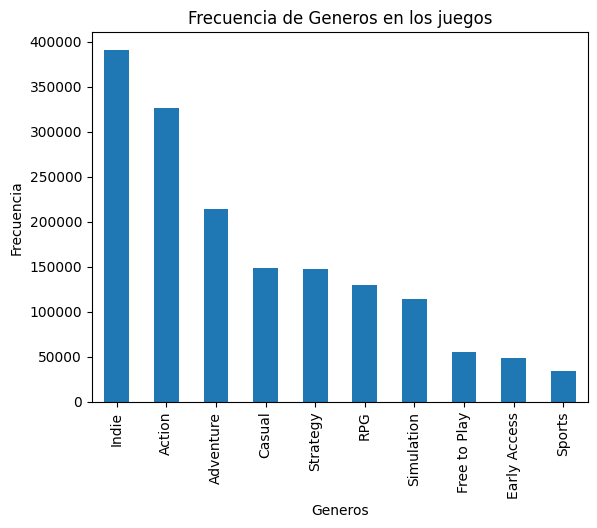

In [21]:
# Se obtienen los valores únicos de los generos de los juegos y se grafica su frecuencia
Conteo = df_Steam_Games["genres"].value_counts().nlargest(10)

Conteo.plot(kind='bar')
plt.xlabel('Generos')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Generos en los juegos')
plt.show()
# De acuerdo a lo que muestra la gráfica, el top 3 de generos de juegos jugados son los de tipo "indie", "Action" y "Adventure"

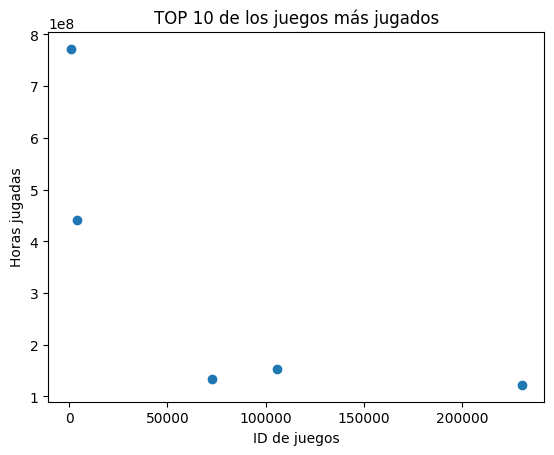

In [39]:
# Se procede a crear un gráfico para saber el top 10 de los juegos más jugados

# Agrupa por la columna 'item_id' y suma los valores de 'playtime_forever'
df_Top_juegos = df_Users_Items.groupby('item_id')['playtime_forever'].sum().reset_index() # Se guarda la agrupación en un datagrame
df_Top_juegos = df_Top_juegos.sort_values(by='playtime_forever', ascending=False) # Se orden el dataframe de forma descendente
top_10 = df_Top_juegos.head(10) # Se toman los primeros 10 resultados

# Se Grafican los resultados
plt.scatter(top_10['item_id'], top_10['playtime_forever']) # Se crea la gráfica de tipo scatter, basado en el id de juegos y las horas jugadas
plt.xlabel('ID de juegos') # La etiqueta del eje X son el ID de juegos
plt.ylabel('Horas jugadas') # La etiqueta en el eje Y son las horas jugadas
plt.title('TOP 10 de los juegos más jugados') # Se coloca el título de la gráfica
plt.show() # Se muestra la gráfica

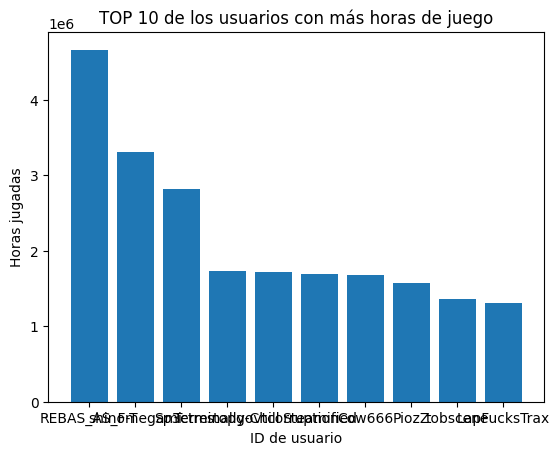

In [41]:
# Se procede a crear un gráfico para saber el top 10 de los jugadores con más horas jugadas

# Agrupa por la columna 'item_id' y suma los valores de 'playtime_forever'
df_Top_juegos = df_Users_Items.groupby('user_id')['playtime_forever'].sum().reset_index() # Se guarda la agrupación en un datagrame
df_Top_juegos = df_Top_juegos.sort_values(by='playtime_forever', ascending=False) # Se orden el dataframe de forma descendente
top_10 = df_Top_juegos.head(10) # Se toman los primeros 10 resultados

# Se Grafican los resultados
plt.bar(top_10['user_id'], top_10['playtime_forever']) # Se crea la gráfica de tipo barra, basado en el id del usuarios y las horas jugadas
plt.xlabel('ID de usuario') # La etiqueta del eje X son el ID del usuario
plt.ylabel('Horas jugadas') # La etiqueta en el eje Y son las horas jugadas
plt.title('TOP 10 de los usuarios con más horas de juego') # Se coloca el título de la gráfica
plt.show() # Se muestra la gráfica

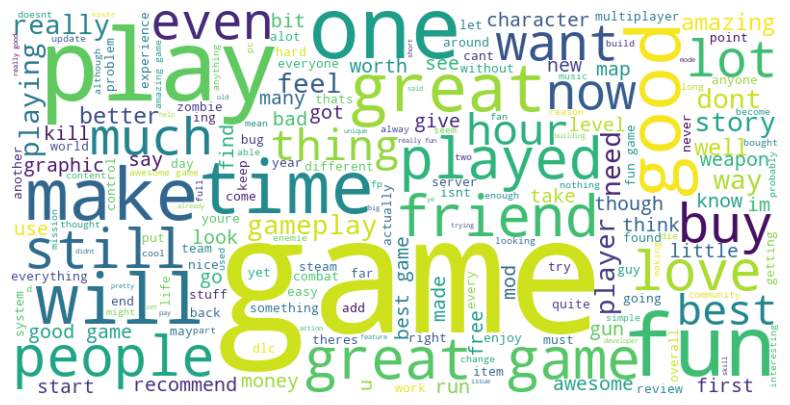

In [45]:
# Vamos a crear una nube de las palabras que destacan en las reviews
# Se Concatenan todos los textos en una sola cadena
Texto = ' '.join(df_User_Reviews['review'].dropna())

# Crea la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(Texto)

# Muestra la nube de palabras utilizando Matplotlib
plt.figure(figsize=(10, 5)) # Se configura el tamaño de la gráfica
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')
plt.show()
# Tal y como se observa el gráfica, dentro de la reseña destacan palabras positvas como "great", " amazing", "love", fun, entre otras

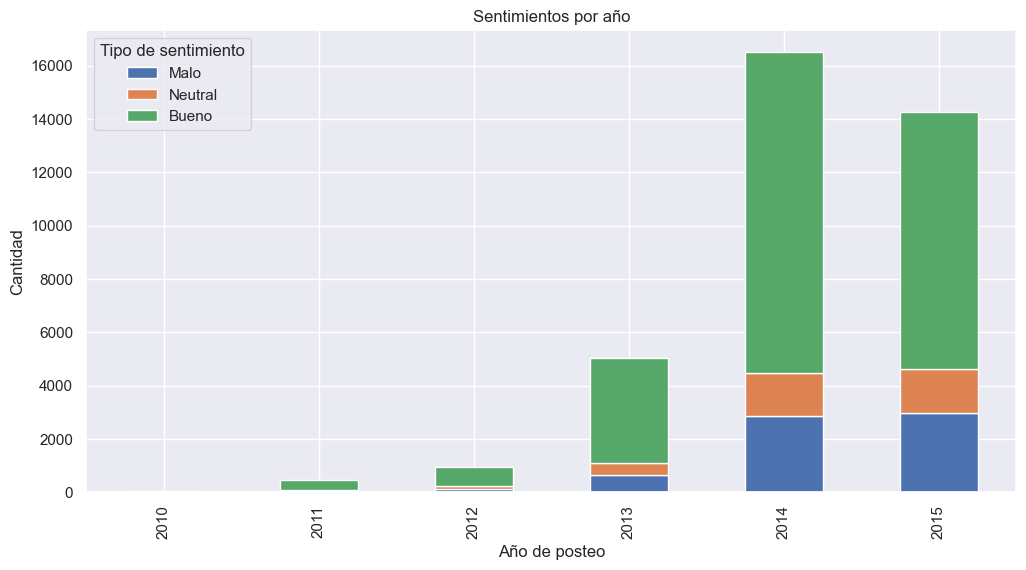

In [46]:
# Se realiza una gráfica para conocer el sentimiento de las reseñas por año
sentimiento_colores = { # Se asigna un diccionario con la definición de los sentimientos
    0: ('Malo'),  
    1: ('Neutral'),
    2: ('Bueno') 
}

# Se tienen que agrupar en primera instancia los datos por año y por el análisis de sentimiento
Datos_Agrupados = df_User_Reviews.groupby(['year', 'sentiment_analysis']).size().reset_index(name='count')
Datos_Pivote = Datos_Agrupados.pivot(index='year', columns='sentiment_analysis', values='count')
sns.set(style='darkgrid')
ax = Datos_Pivote.plot(kind='bar', stacked=True, figsize=(12, 6))

# Se crea la gráfica de barras agrupadas
handles, labels = ax.get_legend_handles_labels()
custom_labels = [sentimiento_colores[int(label)] for label in labels]
ax.legend(handles, custom_labels, title='Tipo de sentimiento', loc='upper left')
plt.ylabel('Cantidad')
plt.xlabel('Año de posteo')
plt.title('Sentimientos por año')
plt.show()

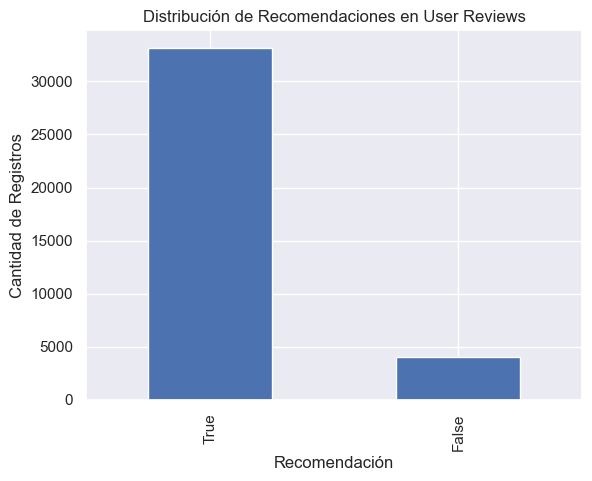

In [49]:
# Se procede a crear un gráfico para conocer el total de recomendacioens y su distribución

Conteo = df_User_Reviews["recommend"].value_counts()

# Crear un gráfico de barras para visualizar las recomendaciones
Conteo.plot(kind='bar')
plt.title('Distribución de Recomendaciones en User Reviews')
plt.xlabel('Recomendación')
plt.ylabel('Cantidad de Registros')
plt.show()
# Esta gráfica nos muestras que en su mayoría cuando un usuario deja un comentario, es positivo